In [3]:
import osmnx as ox 
import torch 
import numpy as np 
import pandas as pd 
import networkx as nx

In [76]:
lat, lon = 51.482957, 5.683390

G = ox.graph_from_point((lat,lon), dist = 200, network_type='drive', simplify=True, retain_all=False)

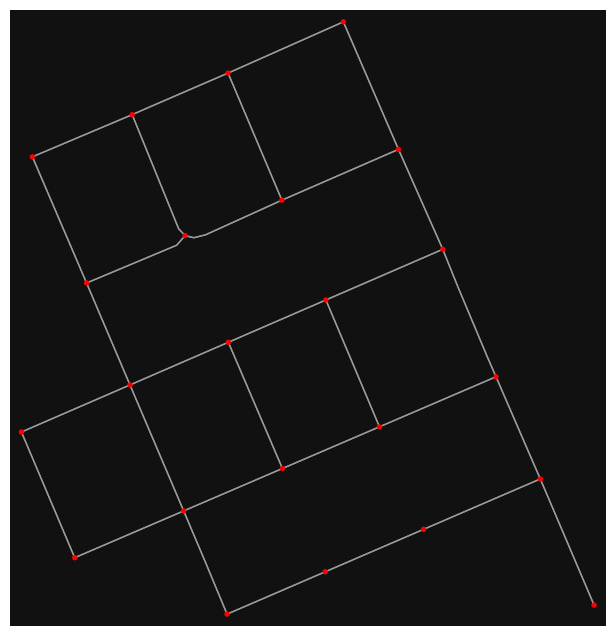

In [77]:
fig, ax = ox.plot_graph(G, node_color ='r' )

In [78]:
nodes, edges = ox.graph_to_gdfs(G)

In [83]:
edges = edges[['maxspeed', 'length']]

In [87]:
edges.loc[:, 'maxspeed'] = edges.maxspeed.astype(float)

In [91]:
edges

maxspeed     length
u        v        key                     
42746889 42747582 0        30.0  64.795523
         42748637 0        30.0  67.831246
42746941 42749183 0        30.0  83.043552
42747582 42746889 0        30.0  64.795523
         42748383 0        30.0  64.872045
...                         ...        ...
42756704 42757669 0        30.0  76.426628
         42755933 0        30.0  63.299791
         42754169 0        30.0  83.622055
42757669 42755300 0        30.0  84.138974
         42756704 0        30.0  76.426628

[62 rows x 2 columns]

In [90]:
nodes = nodes[['y', 'x']]
nodes

,y,x
osmid,,
42746889,51.481285,5.682480
42746941,51.481335,5.685691
42747582,51.481516,5.683339
42747752,51.481592,5.681148
42748383,51.481747,5.684200
42748637,51.481847,5.682101
42749183,51.482022,5.685220
42749335,51.482078,5.682965
42750018,51.482277,5.680682


In [93]:
edges = edges.reset_index()
u = torch.tensor(edges['u'].values, dtype=torch.long)
v = torch.tensor(edges['v'].values, dtype=torch.long)

edge_index = torch.stack([u, v], dim=0)

In [95]:
nodes.loc[:, 'traffic_light'] = 1

In [97]:
# 2. Set traffic light status: randomly 0 (red) or 1 (green)
nodes['traffic_light_status'] = np.random.choice([0, 1], size=len(nodes))

# 3. Set waiting time (in seconds): random between 0 and 60 seconds
nodes['waiting_time_seconds'] = np.random.randint(0, 61, size=len(nodes))

In [99]:
node_features = nodes[['traffic_light', 'traffic_light_status', 'waiting_time_seconds']]

# Convert to tensor
x = torch.tensor(node_features.values, dtype=torch.float)

In [100]:
# Extract u and v (start and end nodes) from edges
edges = edges.reset_index()  # if u, v, key are in the index
u = torch.tensor(edges['u'].values, dtype=torch.long)
v = torch.tensor(edges['v'].values, dtype=torch.long)

# Edge index needs to be shape [2, num_edges]
edge_index = torch.stack([u, v], dim=0)

edge_features = edges[['length', 'maxspeed']]  # pick any other features you need
edge_attr = torch.tensor(edge_features.values, dtype=torch.float)

In [101]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [113]:
static_node_idx = [0]
dynamic_node_idx = [1, 2]
static_edge_idx = [0,1]

x_static = data.x[:, static_node_idx].clone()
x_dynamic = data.x[:, dynamic_node_idx].clone()

if hasattr(data, 'edge_attr'):
    e_static = data.edge_attr[:, static_edge_idx].clone()
else: 
    e_static = e_dynamic = None

data_static = Data(
    x = data.x.new_tensor(x_static),
    edge_index= data.edge_index,
    edge_attr=(e_static if e_static is not None else None)
)

data_dynamic = Data(
    x=data.x.new_tensor(x_dynamic),
    edge_index=data.edge_index,)
    

/tmp/ipykernel_5355/1016503458.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x = data.x.new_tensor(x_static),
/tmp/ipykernel_5355/1016503458.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x=data.x.new_tensor(x_dynamic),


In [114]:
data_static

Data(x=[23, 1], edge_index=[2, 62], edge_attr=[62, 2])

In [117]:
data_dynamic

Data(x=[23, 2], edge_index=[2, 62])

In [109]:
data.edge_attr

tensor([[64.7955, 30.0000],
        [67.8312, 30.0000],
        [83.0435, 30.0000],
        [64.7955, 30.0000],
        [64.8720, 30.0000],
        [82.6889, 30.0000],
        [71.8356, 30.0000],
        [76.9988, 30.0000],
        [64.8720, 30.0000],
        [82.9453, 30.0000],
        [65.0918, 30.0000],
        [67.8312, 30.0000],
        [71.8356, 30.0000],
        [83.0435, 30.0000],
        [67.4550, 30.0000],
        [76.9988, 30.0000],
        [83.1727, 30.0000],
        [65.0918, 30.0000],
        [63.9915, 30.0000],
        [82.6889, 30.0000],
        [71.6592, 30.0000],
        [83.3992, 30.0000],
        [76.8171, 30.0000],
        [63.9915, 30.0000],
        [67.1143, 30.0000],
        [82.9453, 30.0000],
        [64.9556, 30.0000],
        [71.6592, 30.0000],
        [83.6915, 30.0000],
        [67.4550, 30.0000],
        [76.8171, 30.0000],
        [83.1727, 30.0000],
        [64.9556, 30.0000],
        [64.3967, 30.0000],
        [83.3992, 30.0000],
        [77.1655, 30

In [59]:
edges_to_remove = edges[edges['highway'].isin(['trunk', 'busway', 'living_street', 'unclassified', 'residential',])]
for u,v,k in edges_to_remove.index:
    G.remove_edge(u, v, key=k)

In [60]:
nodes, edges = ox.graph_to_gdfs(G)

In [61]:
edges['highway'].value_counts() 

highway
tertiary                        1095
secondary                        565
primary                          133
[unclassified, residential]       73
primary_link                      13
secondary_link                     6
tertiary_link                      5
[residential, living_street]       2
[unclassified, busway]             2
Name: count, dtype: int64

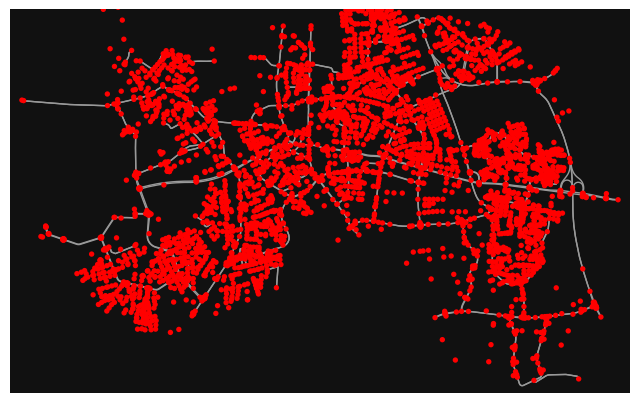

In [62]:
fig, ax = ox.plot_graph(G, node_color ='r' )

In [63]:
# Vind alle nodes zonder verbindingen
isolated_nodes = list(nx.isolates(G))

# Verwijder ze uit de graaf
G.remove_nodes_from(isolated_nodes)

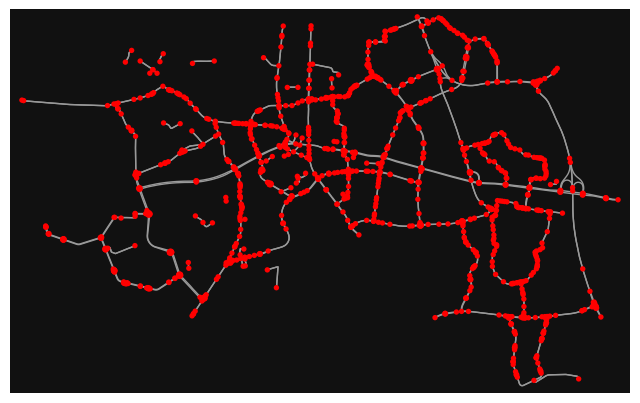

In [64]:
fig, ax = ox.plot_graph(G, node_color ='r' )

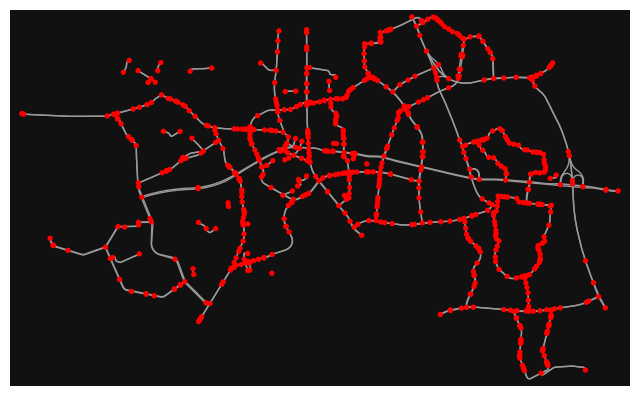

In [65]:
G_projected = ox.project_graph(G)
G2 = ox.simplification.consolidate_intersections(G_projected, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G2, node_color ='r' )